In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
input_path = '/Volumes/Behaviour/2P Tailoring Test Input'
output_path = '/Volumes/Behaviour/Tailored 3sec 2P Trials Test'
beh_stim = pd.read_csv('/Volumes/Behaviour/stimframes.csv', index_col=0)



In [37]:
directories = [x[0] for x in os.walk(input_path) if os.path.basename(x[0]) == 'plane0']

for directory in directories:
    print('Processing:', directory)
    stop = False
    meta = directory.split('/')
    session_name = meta[4]
    print(session_name)
    
    # load Suite2P outputs
    F = np.load(os.path.join(directory, 'F.npy'))
    Fneu = np.load(os.path.join(directory, 'Fneu.npy'))
    iscell = np.load(os.path.join(directory,'iscell.npy'), allow_pickle=True)
                             
    # read trial timings
    sf_path = meta[0]+'/'+meta[1]+'/'+meta[2]+'/'+meta[3]+'/'+meta[4]
    sf = pd.read_csv(os.path.join(sf_path, '2P_stimframes.csv'))
    sf = sf.drop(sf.index[sf['stim_qc'] == 'removed']) # discard 2p timings for trials where behaviour videos were deleted because of qc
    cols = list(sf.columns)
    temp_stim = beh_stim[beh_stim['identifier'].str.contains(str(cols[0]))] # subset stimframes to the session being processed
    
    stimuli = list(sf['stimulus'])
    
    for s, stimulus in enumerate(stimuli):
        temp2_stim = temp_stim[temp_stim['identifier'].str.contains(str(stimulus))] # subset to one stimulus
        values = list(temp2_stim['sframe']) # get list of stimframes for one stimulus
        ids = list(temp2_stim['identifier'])
        sf.loc[sf['stimulus']==stimulus,'sframe']  = values
        sf.loc[sf['stimulus']==stimulus, 'identifier'] = ids
        
    sf_qc = sf.drop(sf.index[sf['sframe'] == 'DO NOT USE']) # keep only trials that passed behavioural qc
    sf_qc = sf_qc[~sf_qc[session_name].isnull()] # remove trial without 2P recording
    sf_qc['2p_correct_frame'] = sf_qc[session_name]+ 18.3 # correct for the three sec arduino delay (3 s *6.1 fps = 18.3 frames)
    sf_qc['2p_stim_ms'] = (sf_qc['2p_correct_frame']*163.9) + 163.9 # convert 2P stimulation frame to msec and add offset (1 frame in ms)
    sf_qc['beh_stim_ms'] = (sf_qc['sframe'].astype(int)*2.5) + 2.5 # convert behaviour stimulation frame to msec and add offset (1 frame in ms)
    sf_qc['2p_realstim_ms'] = sf_qc['2p_stim_ms'] + (sf_qc['beh_stim_ms']-((1203*2.5)+2.5)) # caculate corrected 2P stimulation in ms
    sf_qc['2p_realstim_frame'] = (sf_qc['2p_realstim_ms']/163.9) # convert corrected 2P stimulation to frames
    sf_qc['2p_realstim_frame'] = sf_qc['2p_realstim_frame'].apply(np.ceil) # round up to next completed frame
    
    sf_qc.to_csv(os.path.join(sf_path, '2P_SF_QC.csv'))
    
    stimframes = np.array(sf_qc['2p_realstim_frame'])
    idx = list(sf_qc['identifier'])
    
    # Subtract neuropil signal from raw traces
    Fc = F - 0.7 * Fneu
    print('matrix shape: ', F.shape)
    
    # Get list of ROIS that are not cells
    iscell = pd.DataFrame(iscell)
    iscell_idx = iscell[0] == 1
    
    # Remove non-cell ROIs from raw traces & raw traces without neuropil
    df_F = pd.DataFrame(F)
    F_isCell = df_F.loc[iscell_idx]
    
    df_Fc = pd.DataFrame(Fc)
    Fc_isCell = df_Fc.loc[iscell_idx]
                             
    # remove ROIs with zero values from raw traces and get new list of indecis corresponding to active ROIs
    F_nonZero = F_isCell.loc[~(F_isCell==0).all(axis=1)]
    activeROIs = list(F_nonZero.index.values)
    print('number of active rois: ', len(activeROIs))

    # keep only active ROIs in F-neuropil
    Fc_Act = df_Fc.loc[df_Fc.index[activeROIs]]
    print('active rois matrix shape: ', Fc_Act.shape)
                             
    if stimframes[0]-183 <0: # determine appropriate length of pre-stimulus baseline based on the number 
        TBL_len = stimframes[0]-1 # of frames available before the very first stimulation
    else:
        TBL_len = 183 # default baseline is 30 s (30 * 6.1 fps = 183)
        
        
# for each active ROI, calculate 5th percentile, then cut out 30 sec pre-, and 60 sec post-stimulation 
# traces and use these to calculate F0 (I call it T0 since it is trial based) as the mean of Q5 in the trial window.
# Then, compute trial-wise dF_F0 (I called them dT_T0) an crop those to a 3 second window centered sround stimulation.

    dF_F0_short, dF_F0_short_offset, dF_F0_long = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for r, roi in enumerate(activeROIs):
       
        Fc_Q05 = Fc_Act.iloc[r,:].rolling(366, center = True).quantile(0.05) # 5th percentile of neuropil-corrected F trace
        
        tailored_short, tailored_short_offset, tailored_long = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        
        for s in stimframes:
            start = int(s) - int(TBL_len)
            end = int(s) + 366 # 60 sec * 6.1 fps - 1?
            T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
            T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
            T0 = T_Q05.mean()
            dT_T0_long = (T - T0)/T0
            tailored_long = pd.concat([tailored_long, dT_T0_long], axis=0)
            
            start_short = int(s) - 10 # 1.5 seconds
            end_short = int(s) + 9
            dT_T0_short = dT_T0_long.loc[start_short:end_short]
            tailored_short = pd.concat([tailored_short, dT_T0_short], axis=0)
            
            # use this only to create trial traces to be used for correlation with behaviour videos (1 frame offset)
            end_short_offset = int(s) + 10
            dT_T0_short_offset = dT_T0_long.loc[start_short:end_short_offset]
            dT_T0_short_offset = dT_T0_short_offset[1:]
            tailored_short_offset = pd.concat([tailored_short_offset, dT_T0_short_offset], axis=0)

            
        new_name = session_name + '_' + str(roi)
        dF_F0_short[new_name] = tailored_short[0]
        dF_F0_short_offset[new_name] = tailored_short_offset[0]
    
    print('last trial length: ', dT_T0_short_offset.shape) # checking length of last trial in frames
    
    # add identifier column to dF_F0 dataframes 
    ids = []
    for i in idx:
        for n in range(20):
            #ids = np.append(ids, i)
            ids.append(i)                                       
    ids = np.array(ids) 
    
    dF_F0_short['identifier'] = ids
    dF_F0_short_offset['identifier'] = ids
 
    dF_F0_short.to_csv(os.path.join(output_path,'dF_F0_SHORT_' +session_name+'.csv'))
    dF_F0_short_offset.to_csv(os.path.join(output_path,'dF_F0_SHORT_OFFFSET_' +session_name+'.csv'))

Processing: /Volumes/Behaviour/2P Tailoring Test Input/2P08_Ses01/suite2p/plane0
2P08_Ses01
matrix shape:  (408, 19081)
number of active rois:  204
active rois matrix shape:  (204, 19081)


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


last trial length:  (20,)


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Processing: /Volumes/Behaviour/2P Tailoring Test Input/2P06_Ses06/suite2p/plane0
2P06_Ses06
matrix shape:  (868, 18303)
number of active rois:  347
active rois matrix shape:  (347, 18303)
last trial length:  (20,)
Processing: /Volumes/Behaviour/2P Tailoring Test Input/2P05_Ses07/suite2p/plane0
2P05_Ses07
matrix shape:  (877, 18486)
number of active rois:  376
active rois matrix shape:  (376, 18486)
last trial length:  (20,)


In [11]:
stimframes

array([  367.,   871.,  2331.,  3095.,  4521.,  5265.,  6053.,  6771.,
        7489.,  8239.,  9690., 10426., 11343., 12017., 12977., 13705.,
       14506., 15138., 15949., 16696., 17416., 18111.])

In [12]:
dF_F0 = dF_F0_short.drop(['identifier'], axis = 1)
dF_F0.head()

,2P05_Ses07_0,2P05_Ses07_1,2P05_Ses07_2,2P05_Ses07_4,2P05_Ses07_5,2P05_Ses07_6,2P05_Ses07_7,2P05_Ses07_9,2P05_Ses07_10,2P05_Ses07_11,...,2P05_Ses07_842,2P05_Ses07_845,2P05_Ses07_847,2P05_Ses07_849,2P05_Ses07_850,2P05_Ses07_857,2P05_Ses07_858,2P05_Ses07_859,2P05_Ses07_873,2P05_Ses07_875
357,-0.000155,0.011443,0.010855,0.008738,0.016445,0.011129,0.018375,0.005737,0.013890,0.003279,...,0.007593,0.002662,0.005082,0.004608,0.004414,0.002324,-0.001588,0.000521,0.010694,0.004714
358,0.021609,0.006891,0.024621,0.009615,0.011780,0.001056,0.006548,0.005877,0.015091,0.015792,...,0.004378,0.005991,0.007059,-0.000633,0.004141,0.006335,0.012790,0.005002,0.000483,0.002683
359,0.010386,0.010350,0.030390,0.010663,0.013831,0.005996,0.025586,0.005804,-0.000191,0.000083,...,0.003901,0.004031,0.002122,-0.000708,0.003379,0.007622,0.007215,0.003376,0.004848,0.005333
360,0.007409,-0.001858,0.020297,0.002825,0.018539,-0.001275,0.019506,0.009208,0.016371,-0.000386,...,0.000618,0.004357,0.006114,0.005777,0.008527,-0.001217,0.012228,0.001796,0.007450,0.000949
361,0.009347,0.004662,0.009431,0.008252,0.007583,0.006338,0.012578,0.000371,0.014720,0.011457,...,-0.002713,0.005999,0.000876,0.004852,0.003631,0.005507,0.003792,0.000767,0.007351,0.000625


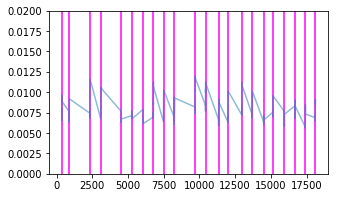

In [34]:
plt.figure(figsize=(5, 3))
#plt.plot(dF_F0.iloc[:,200], alpha=0.5)
plt.plot(dF_F0.mean(axis=1), alpha=0.5)
plt.ylim([0.0,0.02])
#plt.xlim([8220,8260])
plt.eventplot(stimframes, color = 'fuchsia', linelength = 800)
plt.show()

In [8]:
sf_qc['2p_realstim_frame'] = sf_qc['2p_realstim_frame'].apply(np.ceil)

In [9]:
sf_qc.head()

,2P05_Ses07,stimulus,stim_qc,sframe,identifier,2p_correct_frame,2p_stim_ms,beh_stim_ms,2p_realstim_ms,2p_realstim_frame
0,347,off-target,NaN,1203,2P05_Ses07_09NOV2021_off-target_Trial_1_91149,365.3,60036.57,3010.0,60036.57,367.0
1,851,off-target,NaN,1203,2P05_Ses07_09NOV2021_off-target_Trial_2_43748,869.3,142642.17,3010.0,142642.17,871.0
3,2311,hot,NaN,1203,2P05_Ses07_09NOV2021_hot_Trial_1_14902,2329.3,381936.17,3010.0,381936.17,2331.0
4,3075,hot,NaN,1203,2P05_Ses07_09NOV2021_hot_Trial_2_37584,3093.3,507155.77,3010.0,507155.77,3095.0
6,4501,no stim,NaN,1203,2P05_Ses07_09NOV2021_no stim_Trial_1_91568,4519.3,740877.17,3010.0,740877.17,4521.0


In [38]:
dF_F0_short.head()

,2P05_Ses07_0,2P05_Ses07_1,2P05_Ses07_2,2P05_Ses07_4,2P05_Ses07_5,2P05_Ses07_6,2P05_Ses07_7,2P05_Ses07_9,2P05_Ses07_10,2P05_Ses07_11,...,2P05_Ses07_845,2P05_Ses07_847,2P05_Ses07_849,2P05_Ses07_850,2P05_Ses07_857,2P05_Ses07_858,2P05_Ses07_859,2P05_Ses07_873,2P05_Ses07_875,identifier
357,-0.000155,0.011443,0.010855,0.008738,0.016445,0.011129,0.018375,0.005737,0.013890,0.003279,...,0.002662,0.005082,0.004608,0.004414,0.002324,-0.001588,0.000521,0.010694,0.004714,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
358,0.021609,0.006891,0.024621,0.009615,0.011780,0.001056,0.006548,0.005877,0.015091,0.015792,...,0.005991,0.007059,-0.000633,0.004141,0.006335,0.012790,0.005002,0.000483,0.002683,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
359,0.010386,0.010350,0.030390,0.010663,0.013831,0.005996,0.025586,0.005804,-0.000191,0.000083,...,0.004031,0.002122,-0.000708,0.003379,0.007622,0.007215,0.003376,0.004848,0.005333,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
360,0.007409,-0.001858,0.020297,0.002825,0.018539,-0.001275,0.019506,0.009208,0.016371,-0.000386,...,0.004357,0.006114,0.005777,0.008527,-0.001217,0.012228,0.001796,0.007450,0.000949,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
361,0.009347,0.004662,0.009431,0.008252,0.007583,0.006338,0.012578,0.000371,0.014720,0.011457,...,0.005999,0.000876,0.004852,0.003631,0.005507,0.003792,0.000767,0.007351,0.000625,2P05_Ses07_09NOV2021_off-target_Trial_1_91149


In [39]:
dF_F0_short_offset.head()

,2P05_Ses07_0,2P05_Ses07_1,2P05_Ses07_2,2P05_Ses07_4,2P05_Ses07_5,2P05_Ses07_6,2P05_Ses07_7,2P05_Ses07_9,2P05_Ses07_10,2P05_Ses07_11,...,2P05_Ses07_845,2P05_Ses07_847,2P05_Ses07_849,2P05_Ses07_850,2P05_Ses07_857,2P05_Ses07_858,2P05_Ses07_859,2P05_Ses07_873,2P05_Ses07_875,identifier
358,0.021609,0.006891,0.024621,0.009615,0.011780,0.001056,0.006548,0.005877,0.015091,0.015792,...,0.005991,0.007059,-0.000633,0.004141,0.006335,0.012790,0.005002,0.000483,0.002683,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
359,0.010386,0.010350,0.030390,0.010663,0.013831,0.005996,0.025586,0.005804,-0.000191,0.000083,...,0.004031,0.002122,-0.000708,0.003379,0.007622,0.007215,0.003376,0.004848,0.005333,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
360,0.007409,-0.001858,0.020297,0.002825,0.018539,-0.001275,0.019506,0.009208,0.016371,-0.000386,...,0.004357,0.006114,0.005777,0.008527,-0.001217,0.012228,0.001796,0.007450,0.000949,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
361,0.009347,0.004662,0.009431,0.008252,0.007583,0.006338,0.012578,0.000371,0.014720,0.011457,...,0.005999,0.000876,0.004852,0.003631,0.005507,0.003792,0.000767,0.007351,0.000625,2P05_Ses07_09NOV2021_off-target_Trial_1_91149
362,0.011644,0.024944,0.020158,0.009409,0.012034,0.003339,0.004296,0.004246,0.016646,0.005297,...,0.010940,0.007219,0.001360,-0.001407,0.007886,0.006931,0.008970,0.006796,0.011982,2P05_Ses07_09NOV2021_off-target_Trial_1_91149


In [30]:
len(Fc_isCell_old)

378

In [32]:
len(Fc_isCell)

378

In [26]:
len(iscell_idx)

877

In [27]:
iscell_idx

0       True
1       True
2       True
3      False
4       True
       ...  
872    False
873     True
874    False
875     True
876    False
Name: 0, Length: 877, dtype: bool